In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.matplotlib.rcParams['savefig.dpi'] = 144
import seaborn

# Recommendation Engine, Session 1

## Problem definition and data format

The goal of a recommendation engine is to match items to users that will prefer them. We can imagine this being extremely useful across a wide variety of e-commerce applications, for starters.

For this recommendation engine, we start with a set of user ratings. We can use these historical ratings to make guesses about which future items a user will rate highest.  In this tutorial, we will cover two ways of doing this:

1. **Content-based rating:** We can make this guess based only on features of the users or items.
1. **Collaborative Rating:** We could also look at ratings of similar users or similar items.

For an example data set, we are using the [MovieLens 10M dataset](http://files.grouplens.org/datasets/movielens/ml-10m.zip).  This contains about 10M ratings for 10k movies by 72k users.  We will be building applications that attempts to present movies that a given user would rate highly.  Extracting the zip file in the current directory should create a directory called `ml-10M100K/`.  The data wil be in several `.dat` files.  Let's take a look at the list of movies.

In [ ]:
with open('ml-10M100K/movies.dat', 'r') as f:
    for i in xrange(5):
        print f.readline()

Each line has three sections, separated by `::`.  It's easy enough to split them and read each line into a dictionary.
1. The first element is a key, which we will need to identify the movie in the other files.
1. Next is the title, with the year included for disambiguation.
1. We'll go ahead and read that out as a separate feature.
1. The last group is a list of categories, separated by `|`.  We'll convert this to a list.

The `parse_movie_line` function does that for a single line, returning a dictionary of key-value pairs.  Using list comprehension, we can easily run over the entire file.

In [ ]:
def parse_movie_line(l):
    id_, title, cats = l.strip().split('::')
    return {'id': int(id_), 'title': title, 'year': int(title.rsplit(' ')[-1][1:-1]), 
            'categories': cats.split('|')}

with open('ml-10M100K/movies.dat', 'r') as f:
    movies = [parse_movie_line(l) for l in f]

movies[:5]

This is using the built-in Python data types of lists and dictionaries. We'll get much better performance with the *Pandas* module.

If we feed Pandas our list of dictionaries, it does the right thing, making each dictionary a row, with the columns given by the dictionary keys.  By default, Pandas will assign a numerical index to the rows.  Since we have an id key for the movies, we'll use that as the index instead.

In [ ]:
import pandas as pd
df = pd.DataFrame(movies).set_index('id')
df.head()

We'll do the same thing with the tags and ratings data.

In [ ]:
def parse_tag_line(l):
    uid, mid, tag, time = l.strip().split('::')
    return {'user_id': int(uid), 'movie_id': int(mid), 'tag': tag.lower()}

with open('ml-10M100K/tags.dat', 'r') as f:
    df_tags = pd.DataFrame([parse_tag_line(l) for l in f])

df_tags.head()

In [ ]:
'''def parse_rating_line(l):
    uid, mid, rating, time = l.strip().split('::')
    return {'user_id': int(uid), 'movie_id': int(mid), 'rating': float(rating)}

with open('ml-10M100K/ratings.dat', 'r') as f:
    df_ratings = pd.DataFrame([parse_rating_line(l) for l in f])

df_ratings.head()
'''
import itertools
def parse_rating_line(l):
    uid, mid, rating, time = l.strip().split('::')
    return {'user_id': int(uid), 'movie_id': int(mid), 'rating': float(rating)}

with open('ml-10M100K/ratings.dat', 'r') as f:
    df_ratings = pd.DataFrame((parse_rating_line(l)
                               for l in itertools.islice(f, 2000000)))

df_ratings.head()

## Exploring a New Dataset

One of the most important aspects of practical data science work is being able to effectively understand your data. Luckily, Pandas + Jupyter make this easy for us. Let's first take a look at our movie reviews.

In [ ]:
avg_scores = df_ratings.groupby("movie_id")["rating"].agg(["mean", "count", "sum"]).join(df).sort_values("mean", ascending=False)

In [ ]:
pd.concat((avg_scores[["mean", "count", "title"]].head(), # head() gives us the highest rated movies
           avg_scores[["mean", "count", "title"]].tail())) # and tail() gives us the lowest rated ones

We immediately notice our first issue: some of our highest and lowest-rated movies have few ( < 100) reviews. A question that immediately comes to mind is whether or not people rate popular movies differently than unpopular ones. A quick plot indicates this probably isn't the case.

If we wanted to do a more focused analysis, we could compare these distributions with statistical tests, but the purpose of this notebook is to develop a recommendation engine, so we stay focused on that.

In [ ]:
ax = avg_scores["mean"].hist(label="all scores")
avg_scores[avg_scores["count"] > 100]["mean"].hist(ax=ax, label="n > 100")
plt.legend()

Sometimes, it's enough to pick the simplest possible solutions and iterate from there. As a first stab, let's throw together a couple of extremely simple recommenders:

1. A "Most Popular" recommender - we'll use number of reviews as our metric for "best".
2. A "Highest Rated" recommender - this one will be a little more tricky.

In [ ]:
def most_popular_recommender(user_id, num=10):
    most_popular = avg_scores.sort_values("count", ascending=False)[:num]
    return most_popular

most_popular_recommender(2)[["title", "mean", "count"]]

### Highest Rated Recommender

As we saw in our exploration above, we have to worry about the fact that some of our highest-scoring movies have only been rated by one or two users. They're probably not movies we want to recommend as "top rated" to end-users.


### Average Rating Try 1: Naive Sum

Using the sum of the ratings will solve this particular problem...

In [ ]:
df_ratings.groupby("movie_id")["rating"].agg(["sum"]).join(df).sort_values('sum', ascending=False)[["title", "sum"]]

... but will tend to highlight only those popular movies that almost everyone has seen. We could use this as a metric for "most popular" movies!

### Try 2: Bayesian Smoothing

One way to balance these two competing needs is to introduce a **Bayesian prior**.  This is the estimate we make that every movie has a rating $\mu$, before seeing any of the user ratings.  As we see ratings from users come it, we formulate a **posterior** estimate of the rating, taking into account both the prior and the new information provided by the ratings.  The posterior estimate of the rating, after seeing the $n$ reviews $\{x_i\}$, can be written as

$$ \frac{ \sum_{i=0}^n x_i + \mu N}{n + N} \ , $$

where $N$ reflects our level of confidence in the prior.  Adjusting $N$ affects the number of user reviews needed to push the posterior estimate away from $mu$.  Adjusting $mu$ affects where in the rankings movies with few reviews appear.  This technique is known as [Bayesian Smoothing](https://en.wikipedia.org/wiki/Additive_smoothing).

In this case, we use $\mu = 3$, $N = 5$, essentially starting each movie off with five reviews of three stars.

In [ ]:
def bayes_sum(N, mu):
    f = lambda x: (x.sum() + mu*N) / (x.count() + N)
    f.__name__ = "bayes_sum" # a hack to make the column name appear nicely
    return f

df_ratings.groupby("movie_id")["rating"].agg([bayes_sum(5, 3), "count"])\
          .join(df).sort_values("bayes_sum", ascending=False)[["title", "bayes_sum", "count"]]

Much better - this looks like a list of what we'd expect to be "highly rated" movies.

This dataset, however, contains much deeper information about movie category. Let's start to leverage that to develop more sophisticated models and better recommendations.


## Exercise
1. Develop a "by-category" recommendation model - given a category, return the top rated movies from that category. Keep in mind the above discussion about what "top rated" is. This will also help you look into the dataset more closely.
2. Play around with the Bayesian smoothing parameters. Our mean review score is closer to 3.5 , so perhaps we should try that instead of 3? Will that help pull out movies that might be good, but aren't necessarily as popular? Also think about this in your by-category model from 1.

## Feature engineering

Now, let's start thinking about our users and providing tailored recommendations based on their review history.

If a user rated a bunch of Adventure films highly, a simple scheme would be to recommend more Adventure films.  Of course, many users may like several genres of movies, so we need a way to represent categories beyond just the string representing the favorite.

As before, we're going to **vectorize** our categories into a high-dimensional geometric space. From there, we'll try to find the most similar movies given their category. We'll use a technique called K-nearest-neighbors to do this. We'll illustrate with a 2-dimensional example. Let's consider two categories, "Romance" and "Comedy."

In [92]:
rom_coms = df[df.categories.apply(lambda x: 'Romance' in x or 'Comedy' in x)][:15]
rom_coms

,categories,title,year
id,,,
1,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story (1995),1995
3,"[Comedy, Romance]",Grumpier Old Men (1995),1995
4,"[Comedy, Drama, Romance]",Waiting to Exhale (1995),1995
5,[Comedy],Father of the Bride Part II (1995),1995
7,"[Comedy, Romance]",Sabrina (1995),1995
11,"[Comedy, Drama, Romance]","American President, The (1995)",1995
12,"[Comedy, Horror]",Dracula: Dead and Loving It (1995),1995
15,"[Action, Adventure, Romance]",Cutthroat Island (1995),1995
17,"[Comedy, Drama, Romance]",Sense and Sensibility (1995),1995


The first approach for vectorizing the categories might be to assign numbers to each of the categories.  For example, we could say *Adventure* = 1, *Drama* = 2, *Comedy* = 3, and so on.  This approach, however, signals that there is some order to these genres.  This mapping would suggest that *Drama* = (*Adventure* + *Comedy*)/2, which isn't meaningful.  We don't want a movie that is an *Adventure Comedy* to have the same feature as a *Drama*.

Instead, we need to recognize that genre is a **categorical variable**, and thus should be encoded with **one-hot encoding**.  Essentially, this give each genre its own dimension in feature space.  Our *Rom-Com* movie will be located along both the *Romantic* and *Comedy* axes, but at 0 along the *Drama* axis. Let's first demonstrate this along the two dimensions of Romance and Comedy.

In [ ]:
rom_com_dicts = rom_coms.categories.apply(lambda x: {"Romance": (1 if 'Romance' in x else 0), 
                                          "Comedy": (1 if 'Comedy' in x else 0)})
rom_com_dicts.head()

We will use *Scikit Learn's* **transformers** to encode this into a list of feature vectors. In particular, we'll use a `DictVectorizer` - a tool that conveniently one-hot encodes categories provided in dictionary format.

With two dimensions (Romance and Comedy), the `DictVectorizer` is perhaps overkill - however, for the general case, we don't know the categories *a priori*, as we did with the days of the week. In this case, the `DictVectorizer` will help us.  This transformer takes in a list of dictionaries.  Each key in the dictionaries gets mapped to a column, and the values for those keys are placed in the appropriate column.  Columns for keys that are not present in a particular row are filled with zeros.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

rom_com_features = DictVectorizer().fit_transform(rom_com_dicts)
rom_com_features.toarray() # we call toarray() because sklearn gives us back sparse matrices

We see that the first column is our "comedy" feature, and the second column is "romance". We can plot these two dimensions (adding a bit of random noise so the points aren't directly on top of each other).

In [ ]:
import numpy as np

rom_com_features.shape
x_comedy = rom_com_features.toarray()[:, 0] + np.random.normal(scale=.1, size=rom_com_features.shape[0])
y_romance = rom_com_features.toarray()[:, 1] + np.random.normal(scale=.1, size=rom_com_features.shape[0])

plt.scatter(x_comedy, y_romance)
plt.xlabel("Comedy")
plt.ylabel("Romance")

for label, x, y in zip(rom_coms.title, x_comedy, y_romance):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

The below code now generalizes this into many dimensions - using the `DictEncoder` class to take our list of categories and turn it into a dictionary with the same format as the one above.

In [ ]:
from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion

In [ ]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        def to_dict(l):
            try:
                return {x: 1 for x in l}
            except TypeError:
                return {}
        
        return X[self.col].apply(to_dict) if self.col else  X.apply(to_dict)

Once again, a pipeline helps us chain transformers together.  Since the pipeline doesn't end in an estimator, it acts as a transformer instead.

Transformers have a convenience `fit_transform()` method that simply calls `fit()` and then `transform()` immediately afterwards.

In [ ]:
cat_pipe = Pipeline([('encoder', DictEncoder('categories')),
                     ('vectorizer', DictVectorizer())])
features = cat_pipe.fit_transform(df)

The `DictVectorizer` returns a sparse matrix.  This allows efficient operations even on high-dimensional data. This frequently happens - imagine trying to keep track of the counts of words in text data - we'll have thousands of columns, one for each word in the dataset.

In [ ]:
features[0:10].toarray()

## Nearest Neighbors

Now that we have a way to describe a movie, we want to be able to find other movies that are nearby in feature space.  This is the **nearest neighbors** problem, and Scikit Learn provides a class to handle this.

When the `NearestNeighbors` object is fit, it records all of the rows in such a way that it can efficiently look through them to find which is nearest to one queried later.  The `NearestNeighbors` assumes that the closest points are the ones for which the [Minkowski Distance](https://en.wikipedia.org/wiki/Minkowski_distance) is minimized.  That is, if we have two rows of our feature vector $X_{i\cdot}$ and $X_{j\cdot}$, it minimizes
$$ \|X_{i\cdot} - X_{j\cdot}\|_p^p = \sum_k \left(X_{ik} - X_{jk}\right)^p $$
By default, it computes $p=2$, which is the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).

Intuitively, we can understand this from our 2-D example above. If we look for the nearest neighbors to *Get Shorty*, we'll be given back other movies that are at 1 on the "Comedy" dimension and 0 on the "Romance" dimension, since they're closest in the 2-dimensional space. Then (depending on how many neighbors we're looking for), we'd start to get back romantic comedies, and then last, romance movies, since they are farthest away.

In [ ]:
from sklearn.neighbors import NearestNeighbors

rom_nn = NearestNeighbors(n_neighbors=15).fit(rom_com_features)
dists, indices = rom_nn.kneighbors(rom_com_features[0], n_neighbors=15)

neighbors = rom_coms.iloc[indices[0]].reset_index()
neighbors["distance"] = dists[0]
neighbors

Now that we have the intuition, let's run it on the full dataset:

In [ ]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=20).fit(features)

We will discuss how to measure performance of these models later, but for now we will just eyeball the results.  We'll pick out two movies as test cases.  *Toy Story* happens to be the first movie in the data set.  *Dr. Strangelove* is a favorite of the author.

In [ ]:
df.iloc[[0, 737]]

Executing the below, the results for *Toy Story* are reasonable.  All of the movies are animated children's movies, and *Toy Story 2* shows up.  But by relying only on the genres, we are unable to select Pixar movies specifically, for example.

In [ ]:
dists, indices = nn.kneighbors(features[0])
df.iloc[indices[0]]

This limitation is more apparent when looking a movies similar to *Dr. Strangelove*.  We get all the *War Comedy* movies, but that doesn't mean that they're similar to *Dr. Strangelove*.  While the author has never seen *The Wackiest Ship in the Army*, he is pretty sure it is of a rather different tone.

In [ ]:
dists, indices = nn.kneighbors(features[737])
df.iloc[indices[0]]

## Tag Data

The problem is that we're only getting 20 bits of data about each movie from the categories.  We have much more information in the user-applied tags, though, so let's bring that to bear.

As a reminder, the tag data is stored one tag application per row.

In [ ]:
df_tags.head()

In [ ]:
counts = df_tags['tag'].value_counts()
counts

We want all tags for each movie, so we group by the movie_id and get a list of tags.

In [ ]:
all_tags = df_tags.groupby('movie_id')['tag'].apply(lambda x: x.tolist())
all_tags.head(20)

The equivalent of a SQL `join` statement in Pandas is the `merge()` method.  We specify a left join, to keep movies without any tags, and indicate rows should be matched by index, which is the movie_id.

In [ ]:
merged = df.merge(all_tags.to_frame(), left_index=True, right_index=True, how='left')
merged

We'll use the same sort of pipeline to one-hot encode the tags.  (It might be better to use an alternative encoding that accounts for the number of times each tag was applied.)  Then, a `FeatureUnion` can join the two one-hot encoded matrices.

In [ ]:
tag_pipe = Pipeline([('encoder', DictEncoder('tag')),
                     ('vectorizer', DictVectorizer())])
union = FeatureUnion([('categories', cat_pipe),
                      ('tags', tag_pipe)])

In [ ]:
features = union.fit_transform(merged)
features

Nearly 16k features!

In [ ]:
nn = NearestNeighbors(n_neighbors=20).fit(features)
nn.fit(features)

With the tags, we now clearly pick out *Toy Story 2* as the most similar to *Toy Story*.  But the rest seem worse.  We're not getting any of the Pixar movies, for instance.

In [ ]:
dists, indices = nn.kneighbors(features[0])
df.iloc[indices[0]]

The problem becomes more clear looking at *Dr. Strangelove*.  *The Mouse that Roared* is a good pick, but most of the rest have no tags.  The problem is that the tag space is so large, and so sparsely populated, that even similar movies will have very few overlapping tags.  As a result, movies with no tags end up being the closest to most movies.

In [ ]:
dists, indices = nn.kneighbors(features[737])
df.iloc[indices[0]]

## Dimensional Reduction

We don't actually expect there to be 16k different concepts expressed in the tags.  Rather, several tags may be associated with a single underlying concept.  In the above, we can see tags for *animation* and *cartoon*, for example.

There are several methods of **dimensional reduction** that attempt to pull out a lower-dimensional structure.  We'll be using Truncated Singular Value Decomposition (SVD), which works well with sparse matrices.  SVD attempts to find orthogonal directions within feature space, along which the feature matrix has the most variation. It's very closely related to Principal Component Analysis (PCA), a very popular dimensionality reduction and clustering technique.

In fact, it's so popular that it's worth understanding a bit better. Let's give PCA the same treatment we gave K Nearest Neighbors. We'll look at two tags we know to be semantically identical: "adapted from: book" and "based on a book". We can imagine that we don't really need two separate dimensions for these tags (really, we don't need two different tags) - we can collapse them to one single dimension conveying the same meaning. 

Note that we don't see a very dramatic change here in 2 dimensions. PCA (and related decomposition methods) really shines across a high-dimensional feature space with many features, as we'll see.

In [ ]:
first_term = 'adapted from:book'
second_term = 'based on a book'

feat_pipe = Pipeline([('encoder', DictEncoder(None)),
                     ('vectorizer', DictVectorizer()),
                     ])
features = feat_pipe.fit_transform(all_tags)
dv = feat_pipe.steps[1][1]
dv.feature_names_
indexes = [dv.feature_names_.index(first_term), dv.feature_names_.index(second_term)]
term_features = features[:, indexes].toarray()

In [ ]:
first_features = term_features[:, 0]
second_features = term_features[:, 1]

print "variance in first dimension: {}".format(np.var(first_features))
print "variance in second dimension: {}".format(np.var(second_features))

from scipy.stats.stats import pearsonr
print "correlation: {}".format(pearsonr(first_features, second_features )[0])

# plot features + random noise to show density
first_plot = first_features + np.random.normal(scale=.1, size=features.shape[0])
second_plot = second_features + np.random.normal(scale=.1, size=features.shape[0])
plt.scatter(first_plot, second_plot)
plt.xlabel(first_term)
plt.ylabel(second_term)
# plot linear regression line
fitlinePars = np.polyfit(first_features ,second_features,1)
fitline = np.poly1d(fitlinePars)
plt.plot(first_features,fitline(first_features), 'r-')


Now, the idea is that if we set this single line as a dimensional basis for our space, we can throw out the second dimension because that first dimension explains most of the variability. Then we just need to remember the distance along the regression line, and how to encode our features into that basis (relative to the line). As it turns out, this is basically a rotation.

In [ ]:

def rotMatrix(angle):
    return np.array([[np.cos(angle), np.sin(angle)],
                    [-np.sin(angle), np.cos(angle)]])

# remember this from high school math?
angle = -np.arctan(fitlinePars[0])

rotated = np.dot(term_features, rotMatrix(angle))
rotated_line = np.dot(np.column_stack((first_features,fitline(first_features))), rotMatrix(angle))

#rotated = np.array([rotate(x, y, angle - .4) for x, y in zip(first_center, second_center)])
noise = np.random.normal(scale=.1, size=rotated.shape[0])
noise2 = np.random.normal(scale=.1, size=rotated.shape[0])
plt.scatter(rotated[:, 0] + noise, rotated[:, 1] + noise2)

plt.plot(rotated_line[:, 0],rotated_line[:, 1], 'r-')

print "new variances: {}, {}".format(np.var(rotated[:, 0]) , np.var(rotated[:, 1]))


### Now, translated into math...
Recall that for $X$, an $n \times p$ feature matrix, we have the [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) with

$$ X = U \Sigma V^T $$

where $U$ is a unitary $n \times n$ matrix, $\Sigma$ is a diagonal $n \times p$ matrix, and $V$ is a unitary $p \times p$ matrix.  With this decomposition, we can then truncate the diagonal matrix $\Sigma$ to include only the $m$ dimensions with the most variation.

Our choice of $m=100$ seems reasonable, but can be tuned to adjust the sensitivity to the tags. 

We'll use `TruncatedSVD` instead of PCA for two reasons:
1. It plays nice with sparse matrices
2. It works well with term count matrices in documents. It is actually also known as LSA (latent semantic analysis) in the NLP world.

In [ ]:
from sklearn.decomposition import TruncatedSVD

tag_svd_pipe = Pipeline([('encoder', DictEncoder('tag')),
                     ('vectorizer', DictVectorizer()),
                     ('svd', TruncatedSVD(n_components=100))])
svd_union = FeatureUnion([('categories', cat_pipe),
                      ('tags', tag_svd_pipe)])

In [ ]:
svd_features = svd_union.fit_transform(merged)
svd_features

In [ ]:
svd_nn = NearestNeighbors(n_neighbors=20).fit(svd_features)
svd_nn.fit(svd_features)

Now we seem to be getting mostly Disney movies for *Toy Story*, which seems reasonable.

In [ ]:
dists, indices = svd_nn.kneighbors(svd_features[0])
df.iloc[indices[0]]

Now, the algorithm finds movies like *The Great Dictator* and *MASH*, which are fairly similar in message to *Dr. Strangelove*.  It also finds *Full Metal Jacket*, another Stanley Kubrick war movie, albeit with a very different tone.

In [ ]:
dists, indices = svd_nn.kneighbors(svd_features[737])
df.iloc[indices[0]]

We can examine the directions in feature space that the SVD picked out.  Here, we print the top ten tags associated with each dimension of the SVD.  We can see dimensions corresponding to classic movies, sci-fi franchises, comedies, and movies adapted from books.  (Note that the SVD has found that "based on a book", "adapted from:book", and "based on book" are all associated with each other.)

In [94]:
svd = tag_svd_pipe.named_steps['svd']
vect = tag_svd_pipe.named_steps['vectorizer']
[("[" + ", ".join([vect.feature_names_[i] for i in c.argsort()[:-10:-1]]) + "]")
 for c in svd.components_]

["[tumey's dvds, imdb top 250, owned, erlend's dvds, dvd, classic, seen more than once, based on a book, r]",
 '[r, clearplay, owned, nudity (topless), action, seen at the cinema, movie to see, seen more than once, dvd]',
 'm, seen more than once, dvd, action, classic, seen at the cinema, futuristmovies.com, franchise, comedy]',
 '[less than 300 ratings, based on a book, adapted from:book, national film registry, classic, 70mm, afi 100, movie to see, afi 100 (cheers)]',
 '[less than 300 ratings, stylized, 70mm, atmospheric, tense, criterion, quirky, humorous, seen more than once]',
 '[based on a book, adapted from:book, stylized, atmospheric, criterion, disturbing, based on book, tense, betamax]',
 '[comedy, quirky, funny, humorous, romance, seen more than once, satirical, irreverent, classic]',
 "[tumey's dvds, less than 300 ratings, owned, bibliothek, based on a book, adapted from:book, movie to see, eric's dvds, own]",
 '[movie to see, imdb top 250, owned, national film registry, te

## Another alternative: NMF

When our feature matrix contains non-negative features, we can use another extremely similar algorithm, Non-Negative Matrix Factorization (NMF), to reduce our feature space in a nicely explainable way. 

If we absorb the $\Sigma_m$ into $U$ and $V^T$ as $W$ and $H$, we could rewrite this as 
$$ \min_{W, H} \| X - W H \|_2 $$
where $W$ is a $n \times m$ matrix and $H$ is a $m \times p$ matrix.  If $X$ has only non-negative values, we might want $W$ and $H$ to have non-negative values as well.  Hence, Non-negative Matrix Factorization is just
$$ \min_{W \ge 0, H \ge 0} \| X - W H \|_2 $$
when $X \ge 0$ (here, we use $X \ge 0$ to mean that each element of $X$ has non-negative values).  While PCA gives you a more accurate low-dimensional representation, NMF can give a more interpretable results since the values are non-negative.

This is often true of text and image data, where words and pixel value features are strictly "positive" and we'd like our lower-dimensional representations to also be positive. For example, it can be useful to think of text data this way:

![Annotated Wikipedia NMF diagram](nmf_example.png)

Just like in PCA, we have to choose the number of "archetypes" $m \ll n,p$ in order to compress the data, but the larger $m$, the more variance is retained.

In scikit, the matrix $H$ is called the `components_` while $W$ is the value returned from `.transform`.

Below, we are analyzing images of faces.  Each row is a greyscale 64 x 64 dimensional image so the feature space is 4096 dimensional!

In [66]:
from sklearn.decomposition import NMF

tag_nmf_pipe = Pipeline([('encoder', DictEncoder('tag')),
                     ('vectorizer', DictVectorizer()),
                     ('nmf', NMF(n_components=100))])
nmf_union = FeatureUnion([('categories', cat_pipe),
                      ('tags', tag_nmf_pipe)])

nmf_features = nmf_union.fit_transform(merged)
nmf_nn = NearestNeighbors(n_neighbors=20).fit(nmf_features)
nmf_nn.fit(nmf_features)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=1.0)

In [68]:
dists, indices = nmf_nn.kneighbors(svd_features[737])
df.iloc[indices[0]]

,categories,title,year
id,,,
3022,"[Comedy, War]","General, The (1927)",1927
1445,"[Comedy, War]",McHale's Navy (1997),1997
3049,"[Comedy, War]",How I Won the War (1967),1967
7159,"[Comedy, War]",Two Men Went to War (2003),2003
473,"[Comedy, War]",In the Army Now (1994),1994
5801,"[Comedy, War]","Russians Are Coming, the Russians Are Coming, ...",1966
63810,"[Comedy, War]",When Willie Comes Marching Home (1950),1950
9001,"[Comedy, War]","Wackiest Ship in the Army, The (1960)",1960
157,"[Comedy, War]",Canadian Bacon (1995),1995


In [69]:
dists, indices = nmf_nn.kneighbors(nmf_features[0])
df.iloc[indices[0]]

,categories,title,year
id,,,
1,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story (1995),1995
3114,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story 2 (1999),1999
4016,"[Adventure, Animation, Children, Comedy, Fantasy]","Emperor's New Groove, The (2000)",2000
26662,"[Adventure, Animation, Children, Comedy, Fantasy]",Kiki's Delivery Service (Majo no takkyûbin) (1...,1989
2294,"[Adventure, Animation, Children, Comedy, Fantasy]",Antz (1998),1998
45074,"[Adventure, Animation, Children, Comedy, Fantasy]","Wild, The (2006)",2006
47124,"[Adventure, Animation, Children, Comedy, Fantasy]","Ant Bully, The (2006)",2006
3754,"[Adventure, Animation, Children, Comedy, Fantasy]","Adventures of Rocky and Bullwinkle, The (2000)",2000
53121,"[Adventure, Animation, Children, Comedy, Fantasy]",Shrek the Third (2007),2007


In [ ]:
nmf = tag_nmf_pipe.named_steps['nmf']
vect = tag_nmf_pipe.named_steps['vectorizer']
[("[" + ", ".join([vect.feature_names_[i] for i in c.argsort()[:-10:-1]]) + "]")
 for c in nmf.components_]

## A Brief Aside: The Hashing Trick

In many NLP and text-based analysis applications, one-hot encoding each word into its own column can prove extremely expensive, and doesn't boost a model's performance. This is typically known as the *curse of dimensionality*. Instead, we can attempt to take advantage of two properties:

1. The fact that most English words (and in this case, tags) are used infrequently. This is known as [zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law).
2. The structured randomness of hash functions.

Basically, we can use a [hash function](https://en.wikipedia.org/wiki/Hash_function) to map our words to one of `N` bins with uniform randomness. Given that if we point at two random words in the dictionary, it's likely that they will be common words, we get the property that only very uncommon words will collide in the dimensionally reduced feature space.

The hashing trick isn't the best candidate here, but we still demonstrate it.

/Users/sbrice/miniconda3/envs/strata/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


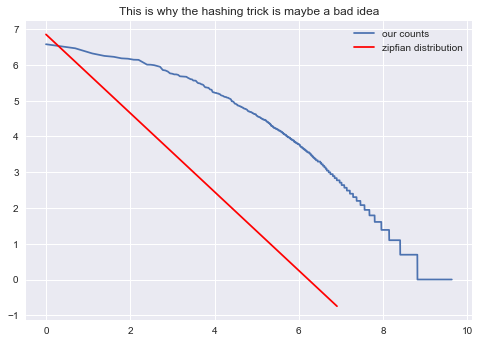

In [70]:
import scipy.stats
import numpy as np
counts = df_tags["tag"].value_counts().sort_values(ascending=False).reset_index()["tag"]
ranks = counts.index + 1
plt.plot(np.log(ranks), np.log(counts), label="our counts")
plt.plot(np.log(range(1000)), np.log(10000* scipy.stats.zipf.pmf(range(1000), 1.1)), 'r-', label="zipfian distribution")
plt.title("This is why the hashing trick is maybe a bad idea")
plt.legend()

In [71]:
from sklearn.feature_extraction.text import HashingVectorizer

class StringEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):            
        return X[self.col].apply(lambda x: (" ".join(x) if isinstance(x, list) else ""))

tag_pipe = Pipeline([('encoder', StringEncoder('tag')),
                     ('vectorizer', HashingVectorizer(n_features=2000, non_negative=True))])

union = FeatureUnion([('categories', cat_pipe),
                      ('tags', tag_pipe)])

features = union.fit_transform(merged)
nn = NearestNeighbors(n_neighbors=20).fit(features)
nn.fit(features)
dists, indices = nn.kneighbors(features[737])
df.iloc[indices[0]]

,categories,title,year
id,,,
750,"[Comedy, War]",Dr. Strangelove or: How I Learned to Stop Worr...,1964
9001,"[Comedy, War]","Wackiest Ship in the Army, The (1960)",1960
7159,"[Comedy, War]",Two Men Went to War (2003),2003
3049,"[Comedy, War]",How I Won the War (1967),1967
63810,"[Comedy, War]",When Willie Comes Marching Home (1950),1950
5801,"[Comedy, War]","Russians Are Coming, the Russians Are Coming, ...",1966
473,"[Comedy, War]",In the Army Now (1994),1994
6561,"[Comedy, War]","Mouse That Roared, The (1959)",1959
3022,"[Comedy, War]","General, The (1927)",1927


Not great, but we'll see that NMF is equally as performant

In [75]:
tag_nmf_pipe = Pipeline([('encoder', StringEncoder('tag')),
                     ('vectorizer', HashingVectorizer(n_features=4000, non_negative=True)),
                     ('nmf', NMF(n_components=100))])
nmf_union = FeatureUnion([('categories', cat_pipe),
                      ('tags', tag_nmf_pipe)])

features = nmf_union.fit_transform(merged)
nn = NearestNeighbors(n_neighbors=20).fit(features)
nn.fit(features)
dists, indices = nn.kneighbors(features[737])
df.iloc[indices[0]]

,categories,title,year
id,,,
750,"[Comedy, War]",Dr. Strangelove or: How I Learned to Stop Worr...,1964
6561,"[Comedy, War]","Mouse That Roared, The (1959)",1959
1078,"[Comedy, War]",Bananas (1971),1971
5789,"[Comedy, War]",All the Queen's Men (2001),2001
3049,"[Comedy, War]",How I Won the War (1967),1967
7159,"[Comedy, War]",Two Men Went to War (2003),2003
5801,"[Comedy, War]","Russians Are Coming, the Russians Are Coming, ...",1966
473,"[Comedy, War]",In the Army Now (1994),1994
9001,"[Comedy, War]","Wackiest Ship in the Army, The (1960)",1960


## Recommendation for a User

The models so far seem to do a pretty good job of suggesting movies similar to a particular movie.  Sometimes, this is all that is needed.  If we notice a user buying a particular movie, we could use this to suggest similar movies they might like.

Often, however, we wish to suggest a movie to a user.  One approach would be to calculate an "average movie" that a particular user enjoyed, and then use the nearest neighbors approach to find movies similar to that one.

To help us judge, we'll add the movie titles to the ratings table.

In [76]:
df_ratings_title = df_ratings.merge(df[['title']], left_on='movie_id', right_index=True)

And we'll look at user 9689, who seems to be a fan of horror.

In [77]:
uid = 9689
df_ratings_title[df_ratings_title.user_id == uid].sort_values('rating', ascending=False)

,movie_id,rating,user_id,title
1320721,2367,5.0,9689,King Kong (1976)
1320715,1982,5.0,9689,Halloween (1978)
1320709,1345,5.0,9689,Carrie (1976)
1320708,1339,5.0,9689,Dracula (Bram Stoker's Dracula) (1992)
1320706,1258,5.0,9689,"Shining, The (1980)"
1320705,1219,4.0,9689,Psycho (1960)
1320717,1994,4.0,9689,Poltergeist (1982)
1320713,1407,4.0,9689,Scream (1996)
1320718,2003,4.0,9689,Gremlins (1984)
1320716,1991,4.0,9689,Child's Play (1988)


We'll compute a weighted average movie, using the scores given as ratings.

In [78]:
m_locs = df_ratings[df_ratings.user_id == uid]['movie_id'].apply(lambda x: df.index.get_loc(x))
scaled_ratings = df_ratings[df_ratings.user_id == uid]['rating'] * 0.2
weighted_avg_movie = scaled_ratings.values.reshape(1,-1).dot(nmf_features[m_locs,:].toarray()) / len(scaled_ratings)

And as expected, we get a bunch of horror movies.

In [79]:
dists, indices = nmf_nn.kneighbors(weighted_avg_movie)
df.iloc[indices[0]]

,categories,title,year
id,,,
4744,[Horror],Jeepers Creepers (2001),2001
7886,[Horror],Countess Dracula (1972),1972
6500,[Horror],"Satanic Rites of Dracula, The (1974)",1974
6913,[Horror],Frankenstein and the Monster from Hell (1974),1974
4518,[Horror],"Lair of the White Worm, The (1988)",1988
2649,[Horror],Son of Frankenstein (1939),1939
2652,[Horror],"Curse of Frankenstein, The (1957)",1957
2868,[Horror],Fright Night Part II (1989),1989
1349,[Horror],Nosferatu in Venice (a.k.a. Vampire in Venice)...,1986


## Cooperative Learning

Content-based recommendation systems work well to find items similar to those a user already likes.  To help with that, we turn to a collaborative learning model.  Instead of finding movies similar to movies a user liked, we will find *users* similar to a given user, and then find the movies that they rated highly.

How do we describe users?  We could use demographic information, but we have better set of features handy: the users' ratings.  Two users are similar if they have rated movies similarly.

In [80]:
by_user_ratings = df_ratings.groupby('user_id').apply(
    lambda items: {i[1]: i[2] for i in items.itertuples()}) # 0 is index
features = DictVectorizer().fit_transform(by_user_ratings)

Previously, we have been using the default [Euclidean metric](https://en.wikipedia.org/wiki/Euclidean_distance) in the nearest neighbors calculation:

$$ d(x, y) =  \left| x - y \right|^2 \ . $$

For users, we will instead use the [cosine metric](https://en.wikipedia.org/wiki/Cosine_similarity),

$$ d(x, y) = 1 - \frac{ x\cdot y}{|x|\ |y|} \ , $$

which cares about angles between vectors in feature space.  This dependence on angle only lessens the effect of users using different scales to rate the movies

In [83]:
nn = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute').fit(features)

In [89]:
user_row = features[by_user_ratings.index.get_loc(uid), :]
dists, indices = nn.kneighbors(user_row)
neighbors = [by_user_ratings.index[i] for i in indices[0]][1:] # value at index 0 is our user themself
ratings_grp = df_ratings_title[df_ratings_title['user_id'].isin(neighbors)] \
    .groupby('title')['rating']
print "{} recommendations".format(len(ratings_grp))
ratings_grp.agg(['mean', 'count']).sort_values('mean', ascending=False).head(5)

419 recommendations


,mean,count
title,,
eXistenZ (1999),5.0,1
If.... (1968),5.0,1
Go (1999),5.0,1
Gladiator (2000),5.0,2
Firestarter (1984),5.0,1


Look at the counts - a familiar problem...

## Exercises

1. At the beginning of this notebook, we discussed Bayesian smoothing. Use Bayesian smoothing to appropriately sort the cooperative recommendations directly above.

2. Explore the effect of different distance metrics on the recommendations.  The 'euclidean', 'manhattan', and 'cosine' metrics are some of the more common ones.  Check the `NearestNeighbors` documentation for additional options.

3. Add in the year as a feature of movies.  Should it be a continuous or categorical variable?  While it's likely that a user who likes movies from 1970 will also like movies from 1971 (suggesting a continuous feature), a user liking movies from 1970 and 1990 is no guarantee that they like movies from 1980 (suggesting a categorical feature).  Can you find an encoding that's in between these two options?  How does the scale of the year, if treated as a continuous feature, affect the KNN calculation?  You may want to use a `StandardScaler`, from `sklearn.preprocessing`, to reduce this effect.

4. In weighting reviews, we consider not reviewing a movie to be less of a recommendation that scoring it a one.  Shift the rating scale to change this, and see how the affects the resultant recommendations.